In [1]:
import os

In [2]:
os.chdir('..')

In [3]:
pwd

'/Users/A.IVA/Documents/jupyter_notebooks/coursera_and_blogs/pytorch/clouds'

In [4]:
data_dir = os.path.join('..', '..', 'data', 'source', 'clouds')

### 0 Generate `test.csv` for the data_loader of the test dataset

In [8]:
import pandas as pd 
import numpy as np
import os
import itertools

In [9]:
def generate_test_csv(data_dir):
    
    files = os.listdir(os.path.join(data_dir, 'test_images'))
    files = filter(lambda x: '.jpg' in x, files)
    files = map(lambda x: [f"{x}_Fish", f"{x}_Flower", f"{x}_Gravel", f"{x}_Sugar"], files)
    files = itertools.chain(*files)
    files = list(files)
    
    # tmp = pd.read_csv(os.path.join(data_dir, 'train.csv'), nrows=20).loc[0, 'EncodedPixels']
    tmp = '1 1'
    df = pd.DataFrame(data=np.array(files).reshape(-1,1), columns=['Image_Label'])
    df = df.sort_values(by=['Image_Label'])
    df['EncodedPixels'] = df['Image_Label'].apply(lambda x: tmp if 'Fish' in x else None)
    
    df.to_csv(os.path.join(data_dir, 'test.csv'), index=False)

In [10]:
files = os.listdir(os.path.join(data_dir, 'test_images'))
files = filter(lambda x: '.jpg' in x, files)
files = map(lambda x: [f"{x}_Fish", f"{x}_Flower", f"{x}_Gravel", f"{x}_Sugar"], files)
files = itertools.chain(*files)
files = list(files)

In [11]:
tmp = pd.read_csv(os.path.join(data_dir, 'train.csv'), nrows=20).loc[0, 'EncodedPixels']
df = pd.DataFrame(data=np.array(files).reshape(-1,1), columns=['Image_Label'])
df = df.sort_values(by=['Image_Label'])
df['EncodedPixels'] = df['Image_Label'].apply(lambda x: tmp if 'Fish' in x else None)
df.head(6)

,Image_Label,EncodedPixels
5092,002f507.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
5093,002f507.jpg_Flower,None
5094,002f507.jpg_Gravel,None
5095,002f507.jpg_Sugar,None
4524,0035ae9.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
4525,0035ae9.jpg_Flower,None


In [12]:
df.to_csv(os.path.join(data_dir, 'test.csv'), index=False)
df_loaded = pd.read_csv(os.path.join(data_dir, 'train.csv'), nrows=20)
df_loaded.head(3)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN


### 1 Plot bounding boxes and masks

In [14]:
from clouds.preprocessing import preprocess_bboxes # , get_lines_from_encoded_pixels
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageDraw, ImageFont

In [16]:
data_path = os.path.join(data_dir, 'train.csv')
df = preprocess_bboxes(data_path, n_el=25)
df.head(4)

,image,pixels
0,0011165.jpg,"{'Sugar': [], 'Gravel': [], 'Flower': [1355565..."
1,002be4f.jpg,"{'Sugar': [67495, 350, 68895, 350, 70295, 350,..."
2,0031ae9.jpg,"{'Sugar': [658170, 388, 659570, 388, 660970, 3..."
3,0035239.jpg,"{'Sugar': [], 'Gravel': [65400, 380, 66800, 38..."


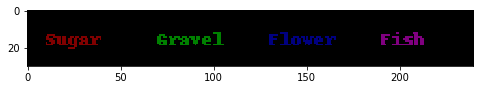

In [17]:
from clouds.utils import see_colors_map
see_colors_map()

In [18]:
from clouds.visualization import create_labeled_image

images = [create_labeled_image(img_path = os.path.join(data_dir, 'train_images', df.loc[idx]['image']), 
                               data = df.loc[idx]['pixels']) 
          for idx in range(20)]

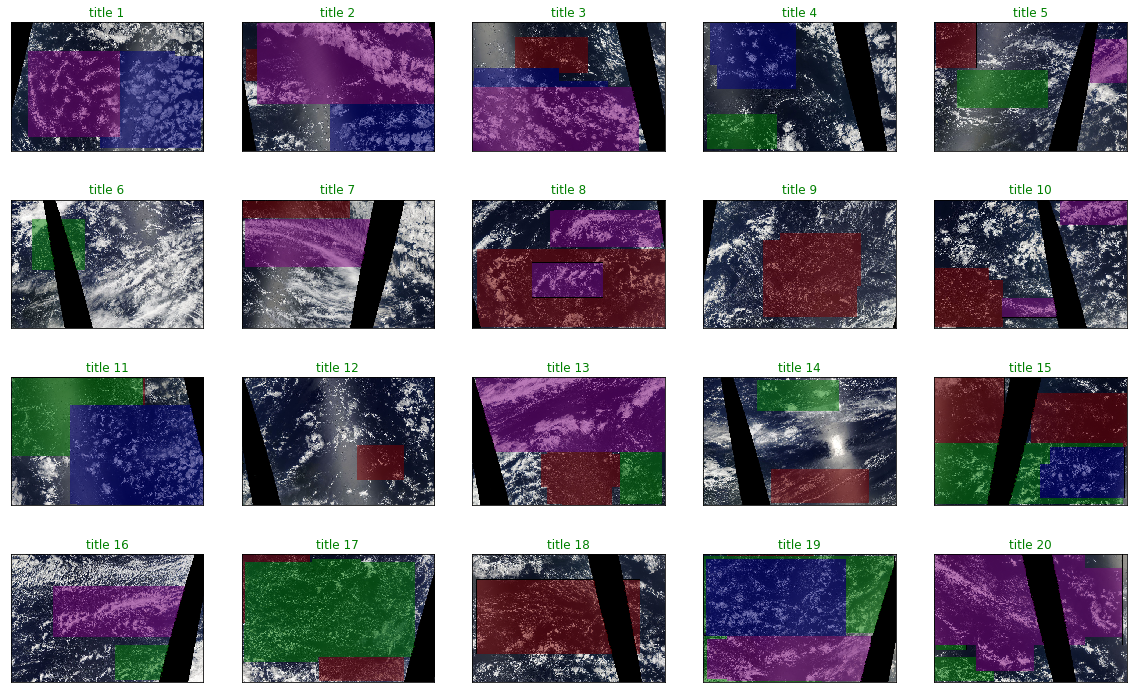

In [19]:
n = len(images) 
columns = 5
rows = math.ceil(n / float(columns))

fig = plt.figure(figsize=(20, 2.5 * columns))

for idx, image in enumerate(images, start=1):
        
    
    ax = fig.add_subplot(rows, columns, idx, xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("title {0:d}".format(idx), color="green")

plt.pause(0.001)
plt.show()

### 2 Map regions of the same class to several bboxes

##### 2.1 Use a connected components detector to identify non-connected regions of the same type (test)

In [26]:
import cv2
import numpy as np

tmp = np.zeros(shape=(4,6))
tmp[np.array([0,0,1]), np.array([0,1,1])] = 1
tmp[np.array([3,3,3]), np.array([0,1,2])] = 1
tmp[np.array([1,1,2,2]), np.array([4,5,4,5])] = 1

nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp.astype(np.uint8), connectivity=4)

display(tmp)
display(nLabels)
display(labels)

array([[1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 0., 0., 0.]])

4

array([[1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 2, 2],
       [0, 0, 0, 0, 2, 2],
       [3, 3, 3, 0, 0, 0]], dtype=int32)

In [27]:
sub_masks = [(labels==el).astype(int) for el in range(1,nLabels)]
for sub_mask in sub_masks:
    display(sub_mask)

array([[1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0]])

##### 2.2 Assign a square-shaped bounding box to all every mask

In [32]:
# At the moment, I am not using skimage.measure.regionproposals
#

from skimage.measure import label, regionprops

tmp = np.zeros(shape=(4,6))
tmp[np.array([0,0,1]), np.array([0,1,1])] = 1
tmp[np.array([3,3,3]), np.array([0,1,2])] = 1
tmp[np.array([1,1,2,2]), np.array([4,5,4,5])] = 1

nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp.astype(np.uint8), connectivity=8)

regions = regionprops(label_image=labels)

# min_row, min_col, max_row, max_col 
# Pixels belonging to the bounding box are are in the half-open interval 
# [min_row; max_row) and [min_col; max_col)
print('bounding boxes')
print(regions[0].bbox, regions[1].bbox, regions[2].bbox, '\n',sep='\t')
print('labels')
print(labels)

bounding boxes
(0, 0, 2, 2)	(1, 4, 3, 6)	(3, 0, 4, 3)	

labels
[[1 1 0 0 0 0]
 [0 1 0 0 2 2]
 [0 0 0 0 2 2]
 [3 3 3 0 0 0]]


### 3 Check if the decoded pixels are within the expected boudaries

##### 3.1 Create a list of images that will be dropped from the training set

In [155]:
# bad_img_annotations = ['0741fda.jpg', '1860780.jpg', '2e324d9.jpg', '40db224.jpg', '4e29ef1.jpg', 
#                        '506e9d9.jpg', '7229f89.jpg', '8639a89.jpg', '888f3b3.jpg', '9c103e5.jpg', 
#                        'b30a770.jpg', 'b5f39d9.jpg', 'bb81b7b.jpg', 'c0c8d52.jpg', 'c3d60e6.jpg', 
#                        'ccafdde.jpg', 'd7591b4.jpg', 'd9bc3a5.jpg', 'ddb9ef1.jpg', 'e4e22fd.jpg', 
#                        'f1ddbc8.jpg', 'f5691a9.jpg']

# https://www.kaggle.com/c/understanding_cloud_organization/discussion/105359#latest-629844
bad_img_2 = ['046586a.jpg', '1588d4c.jpg', '1e40a05.jpg', '41f92e5.jpg', '449b792.jpg', 
             '563fc48.jpg', '8bd81ce.jpg', 'b092cc1.jpg', 'c0306e5.jpg', 'c26c635.jpg', 
             'e04fea3.jpg', 'e5f2f24.jpg', 'eda52f2.jpg', 'fa645da.jpg']

# https://www.kaggle.com/c/understanding_cloud_organization/discussion/110650#latest-639010
bad_img_3['5e70931.jpg', '7ca1d0b.jpg','1e40a05.jpg','8bd81ce.jpg','41f92e5.jpg',
          '449b792.jpg','563fc48.jpg','1588d4c.jpg','046586a.jpg','b092cc1.jpg',
          'c26c635.jpg','c0306e5.jpg','e04fea3.jpg','e5f2f24.jpg','ee0ba55.jpg','fa645da.jpg']